In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Inputs

In [2]:
# data
c = 3; d = 2*c + 1 # number of "clusters" in the data
n = 1000
noise = .5
test_size = .2
val_size = .3

# model
# modelName = 'BasicNet'
modelName, h_FCNet = 'FCNet', 20 # 2
# modelName = 'DeepNet'
# modelName = 'DeepNet_degenerateLast'

# seed
seed = 10
def set_seed(seed = 8):
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(seed)

## Data

In [3]:
# synthetic data with c blue clusters
U = np.random.rand(n)
y = [int(x%2) for x in U*d]
X = 2*U-1

U, y, m = [], [], int(n/d)
for i in range(d):
    im = i%2
    if im == 0:
        U.extend(list(i/d+np.random.rand(m)/d))
    else:
        U.extend(list((i-noise/2)/d+np.random.rand(m)*(1+noise)/d))
    y.extend([im] * m)
U, y = np.array(U), np.array(y)
X = 2*U-1

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y,
                                                          test_size=test_size,
                                                          random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval,
                                                  test_size=val_size,
                                                  random_state=seed)

# grid (for plots)
grid = torch.linspace(-1, 1, 50, dtype=torch.float).view(-1,1)

Text(0.5, 1.0, 'toy data')

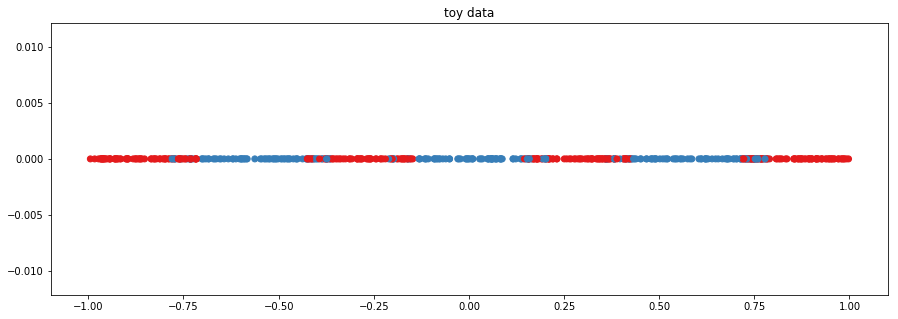

In [4]:
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)
ax.scatter(X_train, 0*y_train, c=cm.Set1(y_train), marker = 'o')
ax.set_title('toy data')

## Experiments

In [5]:
# define model
class BasicNet(nn.Module):
    
    inputDim = 1
    outputDim = 1
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(BasicNet.inputDim, BasicNet.outputDim) # initializes at random
        
    def featurize(self, x):
        return x
    
    def forward(self, x):
        x = self.featurize(x)
        x = torch.sigmoid(self.fc1(x))
        return x
    
    def predict(self, x):
        x = self.forward(x)
        x[x < 1/2] = 0
        x[x>= 1/2] = 1
        return x

In [6]:
# define model
class FCNet(nn.Module):
    
    inputDim = 1
    outputDim = 1
    
    def __init__(self, h):
        """ h: number of units in hidden layer """
        super().__init__()
        
        self.fc1 = nn.Linear(FCNet.inputDim, h) # initializes at random
        self.fc2 = nn.Linear(h, FCNet.outputDim) # initializes at random

    def featurize(self, x):
        x = torch.relu(self.fc1(x))        
        return x
    
    def forward(self, x):
        x = self.featurize(x)
        x = torch.sigmoid(self.fc2(x))
        return x
    
    def predict(self, x):
        x = self.forward(x)
        x[x < 1/2] = 0
        x[x>= 1/2] = 1
        return x

In [7]:
# define model
class DeepNet(nn.Module):
    
    inputDim = 1
    outputDim = 1
    
    def __init__(self, h, degenerateLast=False):
        """
        h: number of units per hidden layer
        """
        super().__init__()
        
        self.fc1 = nn.Linear(DeepNet.inputDim, h) # initializes at random
        self.fc2 = nn.Linear(h, h) # initializes at random
        self.fc3 = nn.Linear(h, h) # initializes at random
        if not degenerateLast:
            self.fc4 = nn.Linear(h, h) # initializes at random
            self.fc5 = nn.Linear(h, DeepNet.outputDim) # initializes at random
        else:
            self.fc4 = nn.Linear(h, 1) # initializes at random
            self.fc5 = nn.Linear(1, DeepNet.outputDim) # initializes at random
            
    def featurize(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return x
        
    def forward(self, x):
        x = self.featurize(x)
        x = torch.sigmoid(self.fc5(x))
        return x
    
    def predict(self, x):
        x = self.forward(x)
        x[x < 1/2] = 0
        x[x>= 1/2] = 1
        return x

In [8]:
# instanciate model and setup
if modelName == 'BasicNet':
    model = BasicNet(); nbEpochs = 100; lr=0.001 # use RMSProp
elif modelName == 'FCNet':
    model = FCNet(h_FCNet); nbEpochs = 100; lr=0.01 # use RMSProp
elif modelName == 'DeepNet':
    model = DeepNet(100); nbEpochs = 500; lr=0.001 # use RMSProp
elif modelName == 'DeepNet_degenerateLast':
    model = DeepNet(100, degenerateLast=True); nbEpochs = 500; lr=0.001 # use RMSProp
else:
    raise ValueError('unkown modelName: {}'.format(modelName))

lossfn = nn.BCELoss() # BinaryCrossEntropy
# optimizer = optim.SGD(model.parameters(), lr=0.1) # using a better optimizer DOES make a difference
optimizer = optim.RMSprop(model.parameters(),
                          lr=lr,
                          alpha=0.99,
                          eps=1e-08,
                          weight_decay=0,
                          momentum=0.9,
                          centered=False)
# optimizer = optim.Adam(model.parameters(),
#                        lr=0.01,
#                        betas=(0.9, 0.999),
#                        eps=1e-08,
#                        weight_decay=0,
#                        amsgrad=False)
for p in model.parameters():
    print(p.size())

torch.Size([20, 1])
torch.Size([20])
torch.Size([1, 20])
torch.Size([1])


[1] error: 0.5148006677627563
[11] error: 0.5091180205345154
[21] error: 0.5061293840408325
[31] error: 0.5038740634918213
[41] error: 0.502479076385498
[51] error: 0.501293957233429
[61] error: 0.5013468265533447
[71] error: 0.5008018612861633
[81] error: 0.49967578053474426
[91] error: 0.4995861053466797
[last] error: 0.49928784370422363
Finished Training


Text(0.5, 1.0, 'train loss')

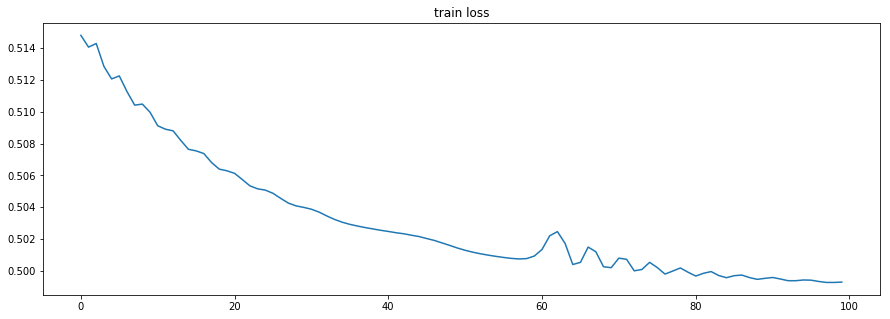

In [12]:
# train model
_X = torch.tensor(X_train, dtype=torch.float).view(-1, 1) # reshape with one column
_y = torch.tensor(y_train, dtype=torch.float).view(-1, 1) # reshape with one column
_aloss = []

for epoch in range(nbEpochs):  # loop over the dataset multiple times
  
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    # no minibatch here: take whole dataset
    fX = model(_X)
    loss = lossfn(fX, _y); _aloss.append(loss)
    loss.backward()
    optimizer.step()
        
    # print statistics
    if epoch % 10 == 0:
        print('[{}] error: {}'.format(epoch + 1, loss))

fX = model(_X)
loss = lossfn(fX, _y)
print('[last] error: {}'.format(loss))

print('Finished Training')

f = plt.figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)
ax.plot(_aloss)
ax.set_title('train loss')

Text(0.5, 1.0, 'prediction')

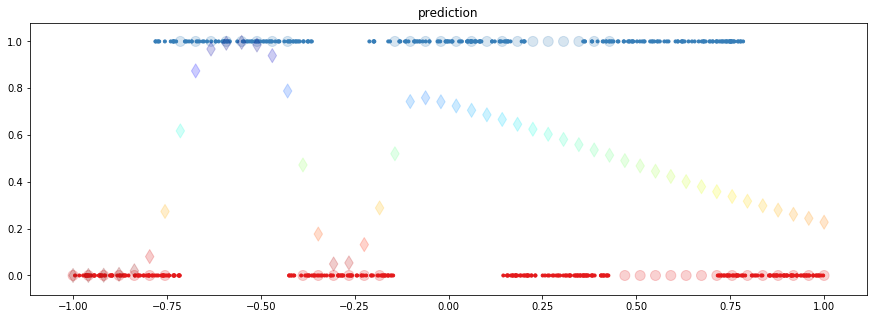

In [13]:
_gridHat = [int(x) for x in model.predict(grid).detach().numpy().flatten()]
_gridHatProb = model(grid).detach().numpy().flatten()

f = plt.figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)
ax.scatter(X_train, y_train, c=cm.Set1(y_train), marker = '.')
ax.scatter(grid, _gridHat, c=cm.Set1(_gridHat), s=100, marker = 'o', alpha=.2)
ax.scatter(grid, _gridHatProb, c=cm.jet(1-_gridHatProb), s=100, marker = 'd', alpha=.2)
ax.set_title('prediction')

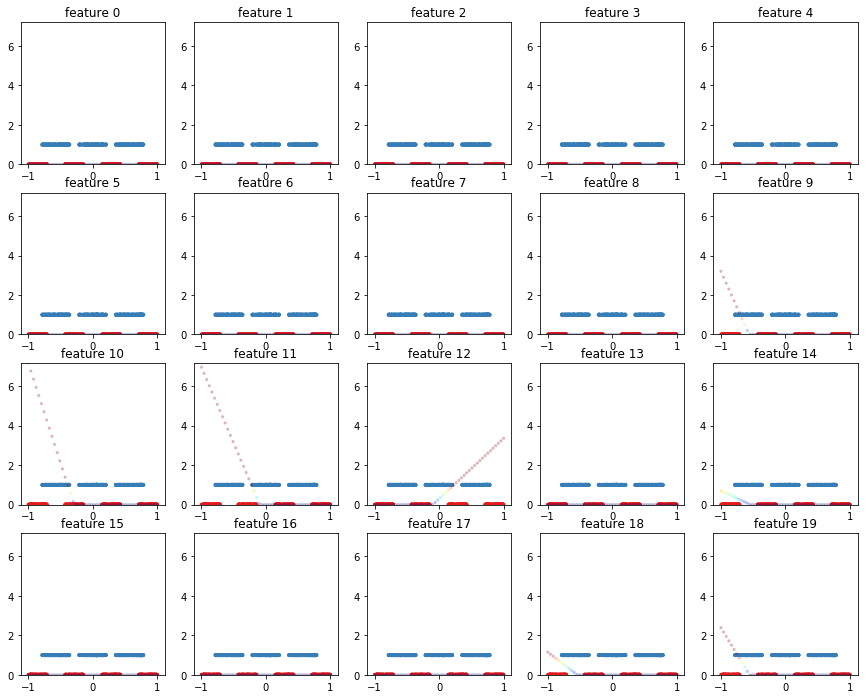

In [14]:
_gridHatFeat = model.featurize(grid).detach().numpy()
_gridHatFeat

K = _gridHatFeat.shape[1]
M = np.max(_gridHatFeat)
nc = 5
nr = int(np.ceil(K/nc))

f = plt.figure(figsize=(3*nc,3*nr))
for k in range(K):
    tmp = _gridHatFeat[:,k]
#     tmp = tmp/np.max(tmp) if np.max(tmp)>0 else 0.*tmp
    
    ax = f.add_subplot(nr,nc,1+k)
    ax.scatter(X_train, y_train, c=cm.Set1(y_train), marker = '.')
    ax.scatter(grid, tmp, c=cm.jet(tmp), s=5, marker = 'o', alpha=.2)
    ax.set_title('feature {}'.format(k))
    ax.set_ylim((0,M))